In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import statsmodels.api as sm

In [83]:
# read data
train_df = pd.read_csv('MELD.Raw/train/train_sent_emo.csv')

In [84]:
# set encoders
emotion_encoder = LabelEncoder()
sentiment_encoder = LabelEncoder()
emotion_encoder.fit(train_df['Emotion'])
sentiment_encoder.fit(train_df['Sentiment'])

In [85]:
emotion_distribution = train_df['Emotion'].value_counts(normalize=True)
emotion_distribution

In [86]:
sentiment_distribution = train_df['Sentiment'].value_counts(normalize=True)
sentiment_distribution

In [87]:
train_df['word_count'] = train_df['Utterance'].apply(lambda x: len(x.split()))

In [88]:
train_df.groupby('Emotion')['word_count'].mean()


In [89]:
top_10_speakers = train_df.groupby('Speaker', as_index=False)['Speaker'].size()
top_10_speakers = top_10_speakers.sort_values(by='size', ascending=False)
top_10_speakers = top_10_speakers['Speaker'].values[0:10]

In [90]:
top_10_speakers

In [91]:
train_df_top_10 = train_df[train_df['Speaker'].isin(top_10_speakers)]

In [92]:
train_df_top_10.groupby('Speaker',)['word_count'].mean()

In [93]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Function to generate and display word clouds
def generate_word_clouds(df, column):
    # Unique categories
    categories = df[column].unique()
    
    # Figure setup
    plt.figure(figsize=(20, 10))
    
    # Generate a word cloud for each category
    for i, category in enumerate(categories, 1):
        # Aggregate text for the current category
        text = " ".join(df[df[column] == category]['Utterance'].tolist())
        
        # Generate word cloud
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text)
        
        # Plot
        plt.subplot(1, len(categories), i)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{category} {column}')
        plt.axis('off')
    
    plt.show()


In [94]:
generate_word_clouds(train_df, 'Sentiment')

In [95]:
generate_word_clouds(train_df_top_10, 'Sentiment')

generate_word_clouds(train_df_top_10, 'Emotion')

In [97]:
generate_word_clouds(train_df, 'Emotion')


In [98]:
generate_word_clouds(train_df_top_10, 'Speaker')

**Audio Features Descriptive Statistics**

**First Version - simple audio features with 3 classes**

In [3]:
#with open('../audio/dev_data.pkl','rb') as file:
#    dev_audio_dict = pickle.load(file)

#with open('../audio/test_data.pkl','rb') as file:
#    test_audio_dict = pickle.load(file)

with open('../AudioFeaturesExtraction/train_data.pkl','rb') as file:
    train_audio_dict = pickle.load(file)

In [4]:
def extract_features(waveform, sr):
    """
    Calculate various spectral features and return them in a dictionary.
    """
    # Basic spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr)[0]
    spectral_flatness = librosa.feature.spectral_flatness(y=waveform)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr)[0]
    rms_energy = librosa.feature.rms(y=waveform)[0]
    zcr = librosa.feature.zero_crossing_rate(waveform)[0]
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr)
    chroma = librosa.feature.chroma_stft(y=waveform, sr=sr)

    # Initialize the feature dictionary
    features = {
        'centroid_mean': np.mean(spectral_centroid),
        'bandwidth_mean': np.mean(spectral_bandwidth),
        'flatness_mean': np.mean(spectral_flatness),
        'rolloff_mean': np.mean(spectral_rolloff),
        'rms_energy_mean': np.mean(rms_energy),
        'zcr_mean': np.mean(zcr)
    }

    # Adding MFCCs and Chroma features
    for i in range(mfccs.shape[0]):  # Assuming MFCCs are returned with shape (n_mfcc, t)
        features[f'mfccs_mean_{i}'] = np.mean(mfccs[i, :])

    for i in range(chroma.shape[0]):  # Assuming Chroma features are returned with shape (n_chroma, t)
        features[f'chroma_mean_{i}'] = np.mean(chroma[i, :])

    return features

def process_audio_data(audio_dict, sample_rate):
    """
    Process each audio scene, extract features, and compile them into a single DataFrame.
    """
    feature_list = []

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()  # Ensure waveform is a NumPy array
        features = extract_features(waveform, sample_rate)
        features['scene_id'] = scene_id  # Add scene_id to the features dictionary
        feature_list.append(features)
    
    # Create a DataFrame from the list of feature dictionaries
    combined_features_df = pd.DataFrame(feature_list)
    return combined_features_df

sample_rate = 16000  # Common sample rate for high-quality audio
#dev_feature_data = process_audio_data(dev_audio_dict, sample_rate)
#test_feature_data = process_audio_data(test_audio_dict, sample_rate)
train_feature_data = process_audio_data(train_audio_dict, sample_rate)

#print(dev_feature_data.head())
#print(test_feature_data.head())
print(train_feature_data.head())

In [44]:
dev = pd.read_csv('dev_fe_16000.csv')

In [45]:
def file_key_generator(file_path, labels_dict):
    info_file = pd.read_csv(file_path)
    # Creating file_key which is a unique identifier for each scene.
    info_file['file_key'] = 'dia' + info_file['Dialogue_ID'].astype(str) + '_' + 'utt' + info_file[
        'Utterance_ID'].astype(str)

    info_file['label'] = info_file['Sentiment'].map(labels_dict)
    info_file = info_file.sort_values(by='file_key')
    return info_file

labels_dict = {
            'negative': 0,
            'neutral': 1,
            'positive': 0}
file_path = '/Users/orl/studies/statistical learning/nlp-with-audio/MELD.Raw/train/train_sent_emo.csv'

dev_info_file = file_key_generator(file_path, labels_dict)

In [46]:
dev_joined_with_audio = dev.merge(dev_info_file[['file_key', 'label']], left_on = 'scene_id', right_on = 'file_key')
dev_joined_with_audio = dev_joined_with_audio.drop(columns=['Unnamed: 0'])
dev_joined_with_audio = dev_joined_with_audio.drop(columns=['fourier_tempogram_mean', 'poly_features_0', 'poly_features_1', 'poly_features_2'])

In [47]:
dev_joined_with_audio.columns

In [48]:
num_cols = ['centroid_median', 'bandwidth_median', 'flatness_median',
       'rolloff_median', 'rms_energy_median', 'zcr_median', 'tempo',
       'tempogram_median', 'tempogram_ratio_median', 'tonnetz_median',
       'mfccs_median_0', 'mfccs_median_1', 'mfccs_median_2', 'mfccs_median_3',
       'mfccs_median_4', 'mfccs_median_5', 'mfccs_median_6', 'mfccs_median_7',
       'mfccs_median_8', 'mfccs_median_9', 'mfccs_median_10',
       'mfccs_median_11', 'mfccs_median_12', 'mfccs_median_13',
       'mfccs_median_14', 'mfccs_median_15', 'mfccs_median_16',
       'mfccs_median_17', 'mfccs_median_18', 'mfccs_median_19',
       'chroma_median_0', 'chroma_median_1', 'chroma_median_2',
       'chroma_median_3', 'chroma_median_4', 'chroma_median_5',
       'chroma_median_6', 'chroma_median_7', 'chroma_median_8',
       'chroma_median_9', 'chroma_median_10', 'chroma_median_11']
df_cor = dev_joined_with_audio[num_cols].corr(method='spearman')

In [49]:
dev_joined_with_audio['label'].value_counts(normalize=True)

In [50]:
dev_joined_with_audio['label'].value_counts(normalize=True)

In [51]:
features = dev_joined_with_audio.columns[:-3]

# Set the aesthetics for the plots
sns.set(style='whitegrid')

# Create a figure to hold the plots
fig, axes = plt.subplots(10, 4, figsize=(20, 50))  # Adjust the layout size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes

for i, feature in enumerate(features):
    # Plot each feature by label in the same subplot
    sns.histplot(data=dev_joined_with_audio, x=feature, hue='label', element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by label')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

# Adjust layout to prevent overlap and save the figure if needed
plt.tight_layout()
plt.show()

**Second Version - simple audio features with 2 classes**

In [53]:
# Assuming 'df' is your DataFrame after joining and cleaning
features = dev_joined_with_audio.columns[:-3]
print(features)
label = dev_joined_with_audio['label']

log_likelihoods = []

for feature in features:
    # Prepare the feature data with an intercept
    X = sm.add_constant(dev_joined_with_audio[feature])  # Adds a constant term to the feature
    y = label

    # Fit logistic regression model
    model = sm.Logit(y, X).fit(disp=0)  # disp=0 turns off the fitting summary output

    # Store the log-likelihood
    log_likelihoods.append(model.llf)  # llf is the log likelihood of the fitted model

# Create a DataFrame to sort features by log-likelihood
results = pd.DataFrame({
    'Feature': features,
    'Log-Likelihood': log_likelihoods
}).sort_values(by='Log-Likelihood', ascending=True)

import matplotlib.pyplot as plt

# Assuming 'results' DataFrame from your code is already prepared and sorted

# Plotting
plt.figure(figsize=(10, 8))
# Scatter plot where we use the index as the y-value and log-likelihood as the x-value
plt.scatter(results['Log-Likelihood'], range(len(results['Feature'])), color='b')

# Setting the y-ticks to show feature names
plt.yticks(range(len(results['Feature'])), results['Feature'])

plt.title('Log-Likelihood of Logistic Regression Models by Feature')
plt.xlabel('Log-Likelihood')
plt.ylabel('Feature')
plt.show()

In [58]:
best_features = results.tail(12)['Feature'].values.tolist()
best_features

**Third Version - more audio features**

In [9]:
def extract_features(waveform, sr):
    """
    Calculate various spectral, rhythmic, and tonal features and return them in a dictionary.
    """
    # Decompose into harmonic and percussive components
    harmonic, percussive = librosa.effects.hpss(waveform)

    # Temporal and spectral features
    tempo, _ = librosa.beat.beat_track(y=waveform, sr=sr)
    onset_env = librosa.onset.onset_strength(y=waveform, sr=sr)
    tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
    fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=onset_env, sr=sr)
    tempogram_ratio = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, win_length=16)
    p_features = librosa.feature.poly_features(S=librosa.stft(waveform), sr=sr, order=2)
    tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sr)

    # Basic spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr)[0]
    spectral_flatness = librosa.feature.spectral_flatness(y=waveform)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr)[0]
    rms_energy = librosa.feature.rms(y=waveform)[0]
    zcr = librosa.feature.zero_crossing_rate(waveform)[0]
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr)
    chroma = librosa.feature.chroma_stft(y=waveform, sr=sr)

    # Initialize the feature dictionary
    features = {
        'centroid_mean': np.mean(spectral_centroid),
        'bandwidth_mean': np.mean(spectral_bandwidth),
        'flatness_mean': np.mean(spectral_flatness),
        'rolloff_mean': np.mean(spectral_rolloff),
        'rms_energy_mean': np.mean(rms_energy),
        'zcr_mean': np.mean(zcr),
        'tempo': tempo,
        'tempogram_mean': np.mean(tempogram),
        'fourier_tempogram_mean': np.mean(fourier_tempogram),
        'tempogram_ratio_mean': np.mean(tempogram_ratio),
        'tonnetz_mean': np.mean(tonnetz)
    }

    # Adding MFCCs and Chroma features
    for i in range(mfccs.shape[0]):
        features[f'mfccs_mean_{i}'] = np.mean(mfccs[i, :])

    for i in range(chroma.shape[0]):
        features[f'chroma_mean_{i}'] = np.mean(chroma[i, :])

    # Adding Polynomial features
    for i in range(p_features.shape[0]):
        features[f'poly_features_{i}'] = np.mean(p_features[i, :])

    return features

def process_audio_data(audio_dict, sample_rate):
    """
    Process each audio scene, extract features, and compile them into a single DataFrame.
    """
    feature_list = []

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()  # Ensure waveform is a NumPy array
        features = extract_features(waveform, sample_rate)
        features['scene_id'] = scene_id  # Add scene_id to the features dictionary
        feature_list.append(features)
    
    # Create a DataFrame from the list of feature dictionaries
    combined_features_df = pd.DataFrame(feature_list)
    return combined_features_df

sample_rate = 16000  # Common sample rate for high-quality audio
# Example of usage in your pipeline
train_feature_data = process_audio_data(train_audio_dict, sample_rate)
print(train_feature_data.head())

In [13]:
def file_key_generator(file_path, labels_dict):
    info_file = pd.read_csv(file_path)
    # Creating file_key which is a unique identifier for each scene.
    info_file['file_key'] = 'dia' + info_file['Dialogue_ID'].astype(str) + '_' + 'utt' + info_file[
        'Utterance_ID'].astype(str)

    info_file['label'] = info_file['Sentiment'].map(labels_dict)
    info_file = info_file.sort_values(by='file_key')
    return info_file

labels_dict = {
            'negative': 0,
            'neutral': 1,
            'positive': 2}
file_path = 'C:/Users/itay/PycharmProjects/nlp-with-audio/MELD.Raw/train/train_sent_emo.csv'

train_info_file = file_key_generator(file_path, labels_dict)
train_info_file_subset = train_info_file[['file_key','label']]
print(train_info_file_subset.head())

train_joined_with_audio = train_feature_data.merge(train_info_file_subset, left_on = 'scene_id', right_on = 'file_key')
print(train_joined_with_audio.head())

features = train_joined_with_audio.columns[:-3]

# Set the aesthetics for the plots
sns.set(style='whitegrid')

# Create a figure to hold the plots
fig, axes = plt.subplots(10, 5, figsize=(20, 50))  # Adjust the layout size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes

for i, feature in enumerate(features):
    # Plot each feature by label in the same subplot
    sns.histplot(data=train_joined_with_audio, x=feature, hue='label', element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by label')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

# Adjust layout to prevent overlap and save the figure if needed
plt.tight_layout()
plt.show()

In [15]:
def file_key_generator(file_path, labels_dict):
    info_file = pd.read_csv(file_path)
    # Creating file_key which is a unique identifier for each scene.
    info_file['file_key'] = 'dia' + info_file['Dialogue_ID'].astype(str) + '_' + 'utt' + info_file[
        'Utterance_ID'].astype(str)

    info_file['label'] = info_file['Sentiment'].map(labels_dict)
    info_file = info_file.sort_values(by='file_key')
    return info_file

labels_dict = {
            'negative': 0,
            'neutral': 1,
            'positive': 0}
file_path = 'C:/Users/itay/PycharmProjects/nlp-with-audio/MELD.Raw/train/train_sent_emo.csv'

train_info_file = file_key_generator(file_path, labels_dict)
train_info_file_subset = train_info_file[['file_key','label']]
print(train_info_file_subset.head())

train_joined_with_audio = train_feature_data.merge(train_info_file_subset, left_on = 'scene_id', right_on = 'file_key')
print(train_joined_with_audio.head())

features = train_joined_with_audio.columns[:-3]

# Set the aesthetics for the plots
sns.set(style='whitegrid')

# Create a figure to hold the plots
fig, axes = plt.subplots(10, 5, figsize=(20, 50))  # Adjust the layout size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes

for i, feature in enumerate(features):
    # Plot each feature by label in the same subplot
    sns.histplot(data=train_joined_with_audio, x=feature, hue='label', element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by label')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

# Adjust layout to prevent overlap and save the figure if needed
plt.tight_layout()
plt.show()

In [16]:
# Assuming 'df' is your DataFrame after joining and cleaning
features = train_joined_with_audio.columns[:-3]
label = train_joined_with_audio['label']

log_likelihoods = []

for feature in features:
    # Prepare the feature data with an intercept
    X = sm.add_constant(train_joined_with_audio[feature])  # Adds a constant term to the feature
    y = label

    # Fit logistic regression model
    model = sm.Logit(y, X).fit(disp=0)  # disp=0 turns off the fitting summary output

    # Store the log-likelihood
    log_likelihoods.append(model.llf)  # llf is the log likelihood of the fitted model

# Create a DataFrame to sort features by log-likelihood
results = pd.DataFrame({
    'Feature': features,
    'Log-Likelihood': log_likelihoods
}).sort_values(by='Log-Likelihood', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Log-Likelihood', y='Feature', data=results)
plt.title('Log-Likelihood of Logistic Regression Models by Feature')
plt.xlabel('Log-Likelihood')
plt.ylabel('Feature')
plt.show()

In [ ]:
def positive_fft(waveform, sr):
    """
    This function computes the FFT of a waveform and returns the positive frequency components and their magnitudes.
    
    Parameters:
    - waveform: The audio waveform array.
    - sr: Sample rate of the audio data.
    
    Returns:
    - pos_frequencies: Positive frequency values.
    - pos_magnitudes: Magnitudes of the FFT at positive frequencies.
    """
    fft_values = np.fft.fft(waveform)
    frequencies = np.fft.fftfreq(len(waveform), 1/sr)
    
    # Filter positive frequencies
    mask = frequencies >= 0
    pos_frequencies = frequencies[mask]
    pos_magnitudes = np.abs(fft_values[mask])
    
    return pos_frequencies, pos_magnitudes

In [ ]:
def plot_average_fft(audio_dict, sample_rate):
    sum_fft = None
    count = 0

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()
        pos_frequencies, pos_magnitudes = positive_fft(waveform, sample_rate)
        
        # Initialize sum_fft if it's the first scene
        if sum_fft is None:
            sum_fft = np.zeros_like(pos_magnitudes)
        
        # Sum the FFT magnitudes
        sum_fft += pos_magnitudes
        count += 1

    # Calculate average FFT
    avg_fft = sum_fft / count

    # Plot the average FFT
    plt.figure(figsize=(10, 5))
    plt.plot(pos_frequencies, avg_fft)
    plt.title('Average FFT Across All Scenes')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Average Amplitude')
    plt.show()

plot_average_fft(dev_audio_dict, 44100)

In [ ]:
def plot_average_filtered_fft(audio_dict, sr, max_freq=5000):
    """
    Computes the average FFT of multiple waveforms stored in a dictionary, and plots the magnitudes up to a specified maximum frequency.
    
    Parameters:
    - audio_dict: Dictionary containing multiple audio data entries. Each entry is expected to have a 'waveforms' key with an audio waveform array.
    - sr: Sample rate of the audio data.
    - max_freq: The maximum frequency to display in the plot.
    """
    sum_fft = None
    count = 0

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()  # Extract waveform and convert to numpy array if necessary
        fft_values = np.fft.fft(waveform)
        frequencies = np.fft.fftfreq(len(waveform), 1 / sr)
        magnitudes = np.abs(fft_values)
        
        # Filter to only show up to max_freq
        mask = (frequencies >= 0) & (frequencies <= max_freq)
        filtered_frequencies = frequencies[mask]
        filtered_magnitudes = magnitudes[mask]
        
        # Initialize sum_fft if it's the first scene
        if sum_fft is None:
            sum_fft = np.zeros_like(filtered_magnitudes)
        
        # Sum the FFT magnitudes
        sum_fft += filtered_magnitudes
        count += 1

    # Calculate average FFT
    avg_fft = sum_fft / count

    # Plot the average FFT
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_frequencies, avg_fft)
    plt.title('Average FFT Across All Scenes (Filtered)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Average Amplitude')
    plt.grid(True)
    plt.show()

plot_average_filtered_fft(dev_audio_dict, 44100, 5000)

In [ ]:
def plot_feature_distributions(feature_data):
    """
    Plots histograms for each spectral feature in the feature DataFrame.
    
    Parameters:
    - feature_data: DataFrame containing the extracted audio features.
    """
    # Prepare the figure layout
    plt.figure(figsize=(20, 20))  # Adjust size as needed for clarity

    # Automatically fetch all feature names except 'scene_id' if it's part of the DataFrame
    features = [col for col in feature_data.columns if col not in ['scene_id']]

    # Determine the number of rows and columns for the subplot grid
    total_features = len(features)
    columns = 4  # Number of columns in the plot grid
    rows = (total_features + columns - 1) // columns  # Calculate required number of rows

    # Create subplots for each feature
    for i, feature in enumerate(features):
        ax = plt.subplot(rows, columns, i + 1)
        # Use a consistent number of bins and alpha transparency for clarity
        plt.hist(feature_data[feature], bins=30, alpha=0.7, color='blue')
        plt.title(feature.replace('_', ' ').capitalize())
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

plot_feature_distributions(feature_data)

In [33]:
def plot_feature_over_scenes(feature_data, feature_name):
    """
    Plot a specified feature for each scene over time or sequence.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(feature_data['scene_id'], feature_data[feature_name], marker='o', linestyle='-')
    plt.title(f'Average {feature_name.replace("_", " ").capitalize()} Over Scenes')
    plt.xlabel('Scene ID')
    plt.ylabel(f'Average {feature_name.replace("_", " ").capitalize()}')
    plt.grid(True)
    plt.xticks([])  # Hides the x-axis labels
    plt.tight_layout()
    plt.show()

features_to_plot = [col for col in feature_data.columns if col != 'scene_id']

for feature in features_to_plot:
    plot_feature_over_scenes(feature_data, feature)


In [7]:
def check_first_audio_properties(audio_dict):
    """
    Check properties of the first waveform in the dictionary of audio data.

    :param audio_dict: Dictionary containing 'waveforms' and 'labels' for audio data.
    """
    # Get the first item from the dictionary
    first_key = next(iter(audio_dict))
    audio_data = audio_dict[first_key]
    
    waveform = audio_data['waveforms']
    label = audio_data['label']
    
    # Assuming waveform is already a tensor, just check if it needs conversion from tensor
    if hasattr(waveform, 'numpy'):  # Convert PyTorch tensor to numpy if necessary
        waveform = waveform.numpy()

    # Assume a single channel waveform or use the first channel
    if waveform.ndim > 1:
        waveform = waveform[0]

    # Sample rate needs to be known beforehand since it's not stored in the dict
    sample_rate = 16000   # Example fixed sample rate; replace with actual if known or if varied, handle accordingly

    print(f"Audio Path: {first_key}")
    print(f"Label: {label}")
    print(f"Sample Rate: {sample_rate}")
    print(f"Max Amplitude in Waveform: {np.max(np.abs(waveform))}")
    
    plt.figure(figsize=(10, 4))
    plt.plot(waveform)
    plt.title(f"Waveform of {first_key}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage:
# Load your train_data.pkl dictionary
# with open('../audio/train_data.pkl', 'rb') as f:
    # train_data_dict = pickle.load(f)

check_first_audio_properties(train_data_dict)

In [10]:
with open('../AudioFeaturesExtraction/train_audio_df.pkl', 'rb') as f:
     train_audio_data = pickle.load(f)

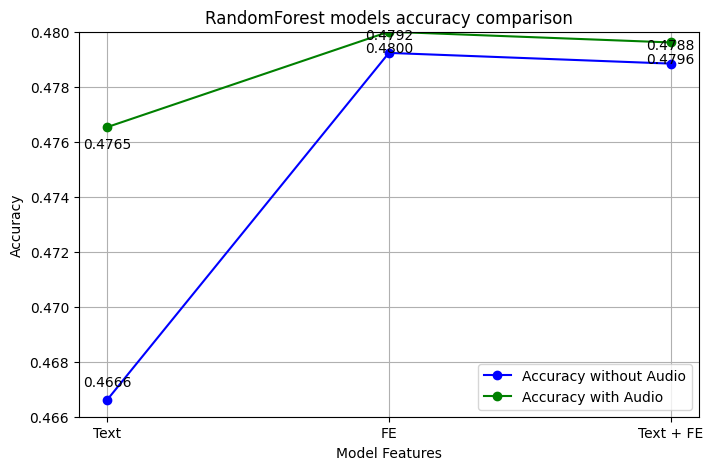

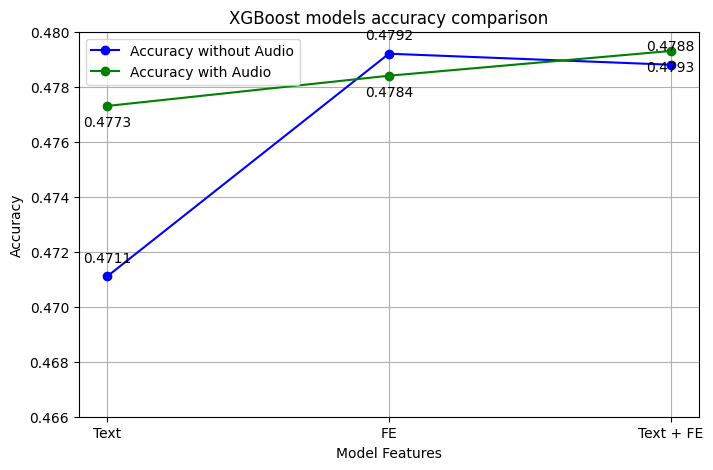

In [6]:
def plot_accuracy_with_values(data, title):
    plt.figure(figsize=(8, 5))
    # Plot the accuracy without audio features
    plt.plot(data['Model Features'], data['Accuracy'], label='Accuracy without Audio', marker='o', color='blue')
    for i, txt in enumerate(data['Accuracy']):
        plt.annotate(f"{txt:.4f}", (data['Model Features'][i], data['Accuracy'][i]), textcoords="offset points", xytext=(0,10), ha='center')
    # Plot the accuracy with audio features
    plt.plot(data['Model Features'], data['Accuracy with Audio features'], label='Accuracy with Audio', marker='o', color='green')
    for i, txt in enumerate(data['Accuracy with Audio features']):
        plt.annotate(f"{txt:.4f}", (data['Model Features'][i], data['Accuracy with Audio features'][i]), textcoords="offset points", xytext=(0,-15), ha='center')
    # Adding labels and title
    plt.xlabel('Model Features')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.ylim(0.466,0.48)
    plt.show()

# Load the Excel file
file_path = '../ModelAccuracy.xlsx'
sheets = ['RandomForest1', 'XGBoost1']

# Read the specified sheets into dataframes
df_random_forest, df_xgboost = [pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets]

# Plotting the data for RandomForest and XGBoost with values next to the dots
plot_accuracy_with_values(df_random_forest, 'RandomForest models accuracy comparison')
plot_accuracy_with_values(df_xgboost, 'XGBoost models accuracy comparison')
